In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv
/kaggle/input/credit-card-fraudssynthetic-dataset/fraudTest.csv/fraudTest.csv
/kaggle/input/credit-card-fraudssynthetic-dataset/fraudTrain.csv/fraudTrain.csv


In [2]:
!pip install -U scikit-learn==1.5.2 imbalanced-learn==0.12.3


In [3]:
import pandas as pd

df_eu = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# Show the first few rows of the dataset
df_eu.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [47]:
# ================== IMPORTS ==================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import clone
import pandas as pd
from imblearn.under_sampling import EditedNearestNeighbours
np.random.seed(42)

df_eu = df_eu.dropna(subset=["Class"])

X_eu = df_eu.drop(columns=["Class"])
y_eu = df_eu["Class"]
# Split into Train, Validation, Test (70/15/15)
X_train_eu, X_temp_eu, y_train_eu, y_temp_eu = train_test_split(
    X_eu, y_eu, test_size=0.3, random_state=42, stratify=y_eu
)
X_val_eu, X_test_eu, y_val_eu, y_test_eu = train_test_split(
    X_temp_eu, y_temp_eu, test_size=0.5, random_state=42
)

print(f"Train: {X_train_eu.shape}, Val: {X_val_eu.shape}, Test: {X_test_eu.shape}")

# ================== HANDLE IMBALANCE ==================

smoteenn = SMOTEENN(
    enn=EditedNearestNeighbours(n_neighbors=5),
    random_state=42
)

X_res_eu, y_res_eu = smoteenn.fit_resample(X_train_eu, y_train_eu)

# ================== MODEL DEFINITION ==================
xgb_params = {
    "n_estimators": 300,
    "max_depth": 7,
    "learning_rate": 0.1,
    "eval_metric": "logloss",
    "reg_lambda": 5,
    "random_state": 42,

}

base_model = XGBClassifier(**xgb_params)

# ================== K-FOLD CV ==================
kf = KFold(n_splits=10, shuffle=True, random_state=42)
f1_scores = []

for train_idx, val_idx in kf.split(X_res_eu, y_res_eu):
    X_tr_eu, X_va_eu = X_res_eu.iloc[train_idx], X_res_eu.iloc[val_idx]
    y_tr_eu, y_va_eu = y_res_eu.iloc[train_idx], y_res_eu.iloc[val_idx]

    model = clone(base_model)
    model.fit(X_tr_eu, y_tr_eu, eval_set=[(X_va_eu, y_va_eu)], verbose=False)

    y_pred_eu = model.predict(X_va_eu)
    f1_scores.append(f1_score(y_va_eu, y_pred_eu))

print("Average 10-Fold F1-score:", np.mean(f1_scores))

# ================== FINAL MODEL ==================
final_model_eu = clone(base_model)
final_model_eu.fit(X_res_eu, y_res_eu, eval_set=[(X_val_eu, y_val_eu)], verbose=True)

y_val_pred_eu = final_model_eu.predict(X_val_eu)
y_test_pred_eu = final_model_eu.predict(X_test_eu)

print("\n===== EU Dataset - XGBoost (SMOTEENN + K-Fold) =====")
print("\n===== Validation Results =====")
print("Acc:", accuracy_score(y_val_eu, y_val_pred_eu),
      "Prec:", precision_score(y_val_eu, y_val_pred_eu, zero_division=0),
      "Rec:", recall_score(y_val_eu, y_val_pred_eu, zero_division=0),
      "F1:", f1_score(y_val_eu, y_val_pred_eu, zero_division=0))

print("\n===== Test Results =====")
print("Acc:", accuracy_score(y_test_eu, y_test_pred_eu),
      "Prec:", precision_score(y_test_eu, y_test_pred_eu, zero_division=0),
      "Rec:", recall_score(y_test_eu, y_test_pred_eu, zero_division=0),
      "F1:", f1_score(y_test_eu, y_test_pred_eu, zero_division=0))


Train: (199364, 30), Val: (42721, 30), Test: (42722, 30)
Average 10-Fold F1-score: 0.9998379682391734
[0]	validation_0-logloss:0.56640
[1]	validation_0-logloss:0.49753
[2]	validation_0-logloss:0.43969
[3]	validation_0-logloss:0.39037
[4]	validation_0-logloss:0.34746
[5]	validation_0-logloss:0.31044
[6]	validation_0-logloss:0.27817
[7]	validation_0-logloss:0.24985
[8]	validation_0-logloss:0.22500
[9]	validation_0-logloss:0.20296
[10]	validation_0-logloss:0.18358
[11]	validation_0-logloss:0.16597
[12]	validation_0-logloss:0.15035
[13]	validation_0-logloss:0.13641
[14]	validation_0-logloss:0.12399
[15]	validation_0-logloss:0.11282
[16]	validation_0-logloss:0.10288
[17]	validation_0-logloss:0.09399
[18]	validation_0-logloss:0.08596
[19]	validation_0-logloss:0.07877
[20]	validation_0-logloss:0.07239
[21]	validation_0-logloss:0.06656
[22]	validation_0-logloss:0.06125
[23]	validation_0-logloss:0.05656
[24]	validation_0-logloss:0.05227
[25]	validation_0-logloss:0.04825
[26]	validation_0-loglos

In [53]:
# ================== IMPORTS ==================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import clone
import pandas as pd
from imblearn.under_sampling import EditedNearestNeighbours
np.random.seed(42)
# Load both files
train_df = pd.read_csv("/kaggle/input/credit-card-fraudssynthetic-dataset/fraudTrain.csv/fraudTrain.csv")
test_df = pd.read_csv("/kaggle/input/credit-card-fraudssynthetic-dataset/fraudTest.csv/fraudTest.csv")


df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
print("Combined dataset shape:", df.shape)


#
print(df.head())



Combined dataset shape: (1852394, 23)
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F 

Train: (1296675, 8), Val: (277859, 8), Test: (277860, 8)
Average 10-Fold F1-score: 0.9935665259511728

===== Sparkov Dataset - XGBoost (SMOTEENN + K-Fold) =====
Validation -> Acc: 0.9930180415246582 Prec: 0.42050951306030315 Rec: 0.9011748445058743 F1: 0.5734388742304309
Test -> Acc: 0.9927733390916289 Prec: 0.41244527829893685 Rec: 0.9109116022099447 F1: 0.5678002582866982


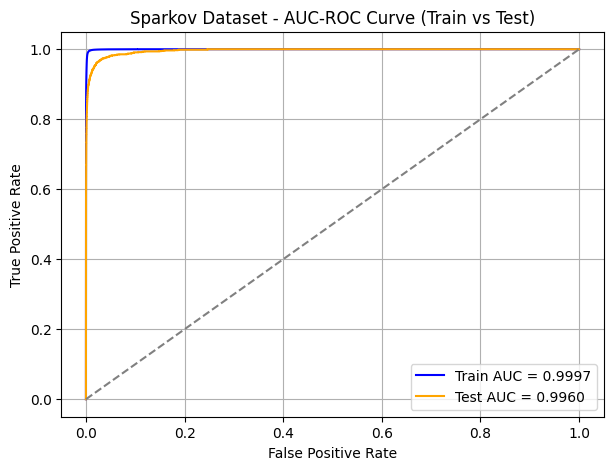

✅ Sparkov Dataset - Train AUC: 0.9997 | Test AUC: 0.9960


In [56]:


# ================== CLEANING ==================
# Drop missing and duplicates
df = df.dropna(subset=['is_fraud']).drop_duplicates()

# Drop irrelevant columns (ignore missing safely)
drop_cols = [
    'unix_time', 'cc_num', 'merchant', 'first', 'last', 'gender',
    'street', 'city', 'state', 'lat', 'long', 'trans_num',
    'merch_lat', 'merch_long'
]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

# --- FIXED DATE PROCESSING ---
df['trans_date_trans_time'] = pd.to_datetime(
    df['trans_date_trans_time'], errors='coerce', utc=True
)
df = df.dropna(subset=['trans_date_trans_time'])
df['trans_date_trans_time'] = df['trans_date_trans_time'].astype('int64') // 10**9

# --- DOB to AGE ---
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
current_year = pd.Timestamp.now().year
df['dob'] = df['dob'].apply(lambda d: current_year - d.year if pd.notnull(d) else np.nan)
df = df.dropna(subset=['dob'])

# ================== ENCODING + SCALING ==================
le = LabelEncoder()
for col in ['category', 'job']:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

scaler = StandardScaler()
features = df.drop(columns=['is_fraud']).columns
df[features] = scaler.fit_transform(df[features])

# ================== SPLIT DATA ==================
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ================== BALANCE WITH SMOTEENN ==================
smoteenn = SMOTEENN(random_state=42, enn=EditedNearestNeighbours(n_neighbors=10))
X_res_sp, y_res_sp = smoteenn.fit_resample(X_train, y_train)

# ================== MODEL & PARAMETERS ==================
xgb_params = {
    "n_estimators": 400,
    "max_depth": 8,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 2,
    "min_child_weight": 6,
    "reg_lambda": 10,
    "reg_alpha": 5,
    "random_state": 42,
    "eval_metric": "aucpr"
}

base_model = XGBClassifier(**xgb_params)

# ================== K-FOLD VALIDATION ==================
kf = KFold(n_splits=10, shuffle=True, random_state=42)
f1_scores = []

for train_idx, val_idx in kf.split(X_res_sp, y_res_sp):
    X_tr, X_va = X_res_sp.iloc[train_idx], X_res_sp.iloc[val_idx]
    y_tr, y_va = y_res_sp.iloc[train_idx], y_res_sp.iloc[val_idx]

    model = clone(base_model)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)
    f1_scores.append(f1_score(y_va, y_pred))

print("Average 10-Fold F1-score:", np.mean(f1_scores))

# ================== FINAL MODEL ==================
final_model_sp = clone(base_model)
final_model_sp.fit(X_res_sp, y_res_sp)

# --- Evaluation ---
y_val_pred = final_model_sp.predict(X_val)
y_test_pred = final_model_sp.predict(X_test)

print("\n===== Sparkov Dataset - XGBoost (SMOTEENN + K-Fold) =====")
print("Validation -> Acc:", accuracy_score(y_val, y_val_pred),
      "Prec:", precision_score(y_val, y_val_pred, zero_division=0),
      "Rec:", recall_score(y_val, y_val_pred, zero_division=0),
      "F1:", f1_score(y_val, y_val_pred, zero_division=0))
print("Test -> Acc:", accuracy_score(y_test, y_test_pred),
      "Prec:", precision_score(y_test, y_test_pred, zero_division=0),
      "Rec:", recall_score(y_test, y_test_pred, zero_division=0),
      "F1:", f1_score(y_test, y_test_pred, zero_division=0))

# ================== AUC-ROC PLOT ==================
def plot_train_test_auc(final_model, X_train, y_train, X_test, y_test, dataset_name):
    y_train_prob = final_model.predict_proba(X_train)[:, 1]
    y_test_prob = final_model.predict_proba(X_test)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

    auc_train = roc_auc_score(y_train, y_train_prob)
    auc_test = roc_auc_score(y_test, y_test_prob)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr_train, tpr_train, color='blue', label=f"Train AUC = {auc_train:.4f}")
    plt.plot(fpr_test, tpr_test, color='orange', label=f"Test AUC = {auc_test:.4f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f"{dataset_name} - AUC-ROC Curve (Train vs Test)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f"✅ {dataset_name} - Train AUC: {auc_train:.4f} | Test AUC: {auc_test:.4f}")

# ================== CALL FUNCTION ==================
plot_train_test_auc(final_model_sp, X_res_sp, y_res_sp, X_test, y_test, "Sparkov Dataset")


In [57]:
y_proba = final_model_sp.predict_proba(X_test)[:, 1]
best_thresh = 0.6  # try 0.55 - 0.8 range

y_pred_thresh = (y_proba > best_thresh).astype(int)

print("Precision:", precision_score(y_test, y_pred_thresh))
print("Recall:", recall_score(y_test, y_pred_thresh))
print("F1:", f1_score(y_test, y_pred_thresh))


Precision: 0.4911153119092628
Recall: 0.8970994475138122
F1: 0.6347422428536525


Generating Accuracy learning curve for EU Dataset...


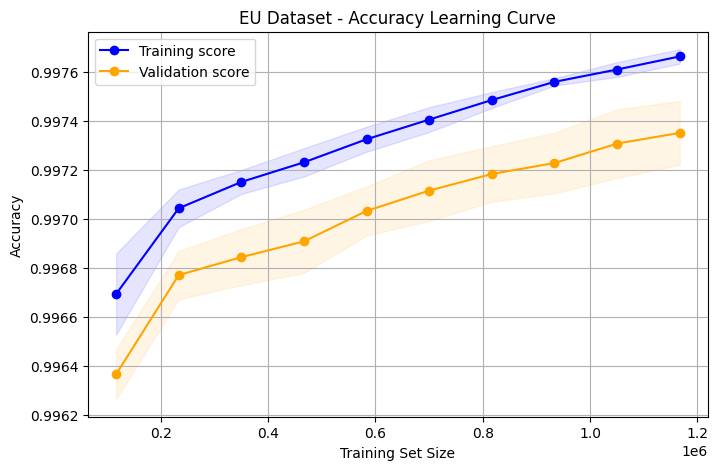

Generating F1-Score learning curve for EU Dataset...


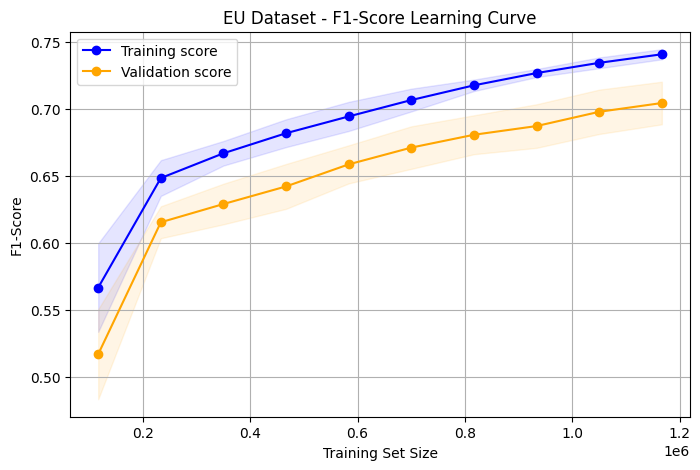

Generating Accuracy learning curve for Sparkov Dataset...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


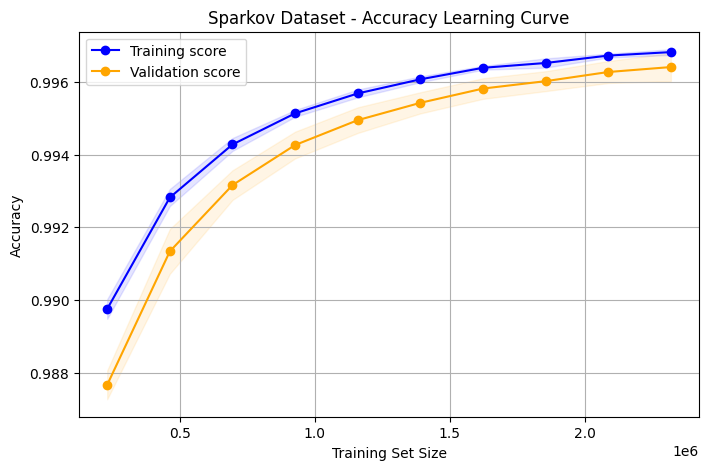

Generating F1-Score learning curve for Sparkov Dataset...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


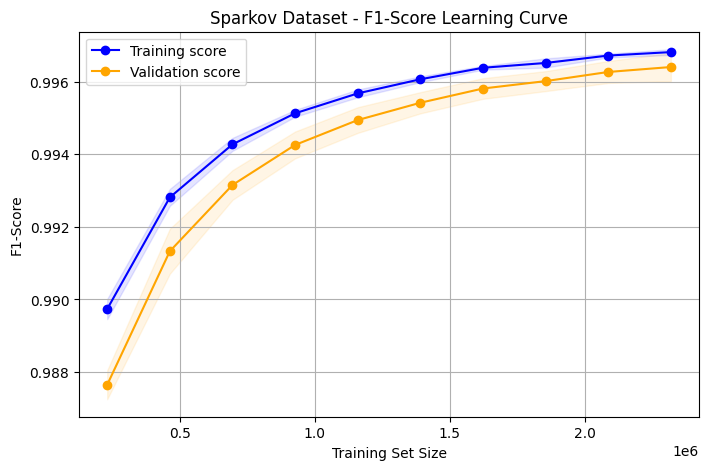

In [8]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(model, X, y, dataset_name):
    # --- Define metrics ---
    metrics = {
        "Accuracy": "accuracy",
        "F1-Score": "f1"
    }

    for metric_name, scoring in metrics.items():
        print(f"Generating {metric_name} learning curve for {dataset_name}...")

        # --- Compute learning curve ---
        train_sizes, train_scores, val_scores = learning_curve(
            model,
            X, y,
            cv=10,
            scoring=scoring,
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            shuffle=True,
            random_state=42
        )

        # --- Mean & Std ---
        train_mean = np.mean(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        # --- Plot ---
        plt.figure(figsize=(8, 5))
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
        plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation score')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
        plt.title(f"{dataset_name} - {metric_name} Learning Curve")
        plt.xlabel("Training Set Size")
        plt.ylabel(metric_name)
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

# ===========================
# Call for each dataset
# ===========================

# For EU (Credit Card)
plot_learning_curves(base_model, X_train, y_train, "EU Dataset")

# For Sparkov
plot_learning_curves(base_model, X_res, y_res, "Sparkov Dataset")


In [9]:
import joblib

joblib.dump(final_model, "xgb_final_eu.pkl")       # for EU dataset
# or
joblib.dump(final_model, "xgb_final_sparkov.pkl")  # for Sparkov dataset


['xgb_final_sparkov.pkl']


================= 🔍 INTERPRETATION FOR EU Dataset =================


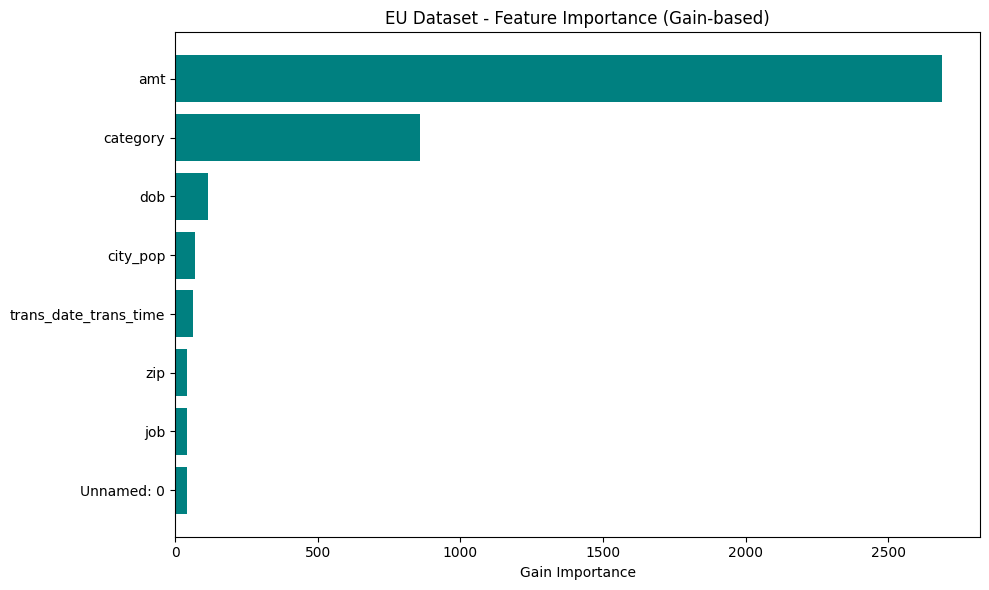


Top 5 important features (EU Dataset):
                 Feature   Importance
3                    amt  2687.339355
2               category   860.234802
7                    dob   115.997009
5               city_pop    68.444183
1  trans_date_trans_time    64.024193

🔁 Computing Permutation Importance (EU Dataset)...


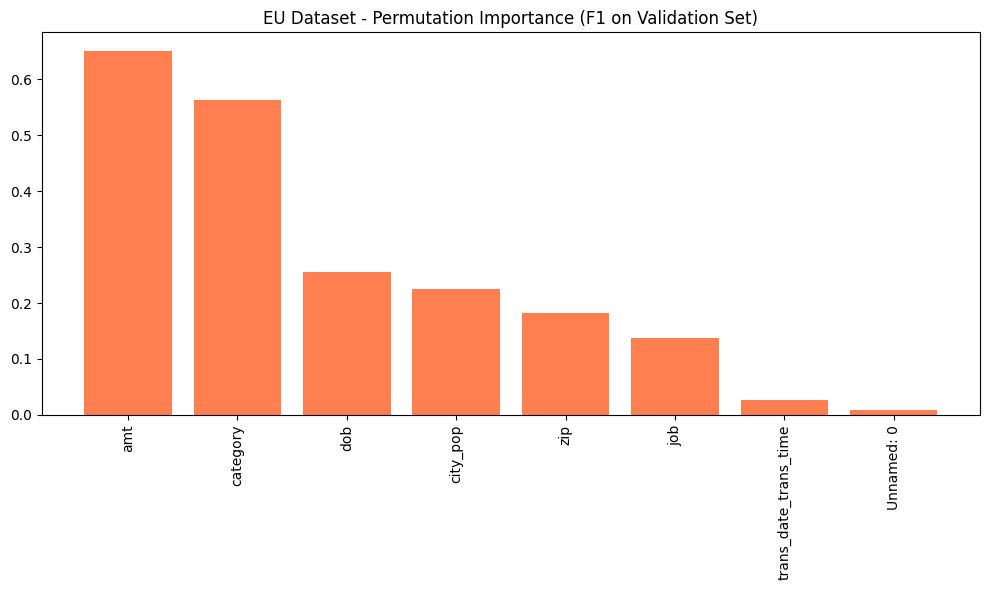


📈 Creating Partial Dependence Plots for top features: ['amt', 'category', 'dob']


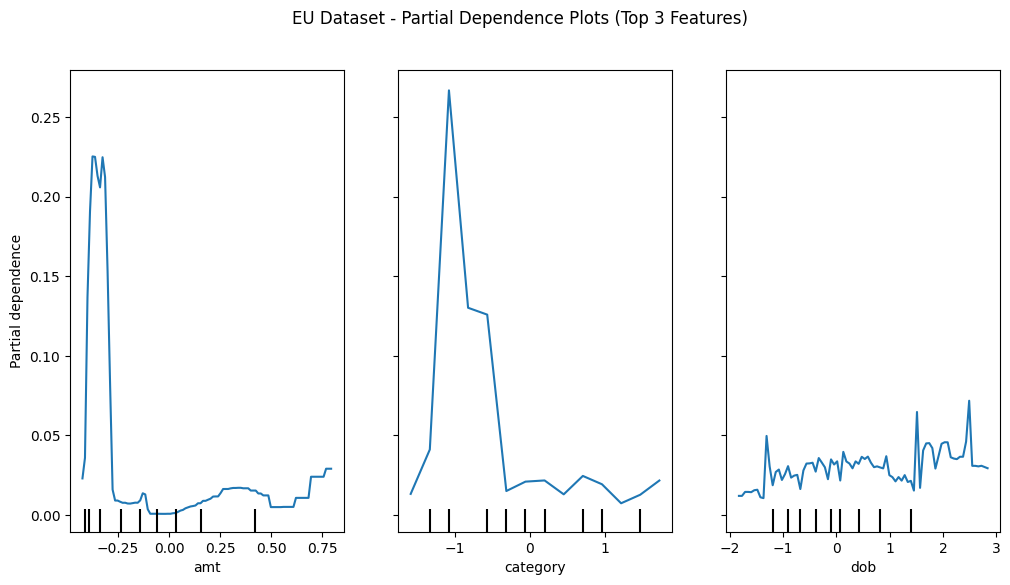


✅ Interpretation completed for EU Dataset.


================= 🔍 INTERPRETATION FOR Sparkov Dataset =================


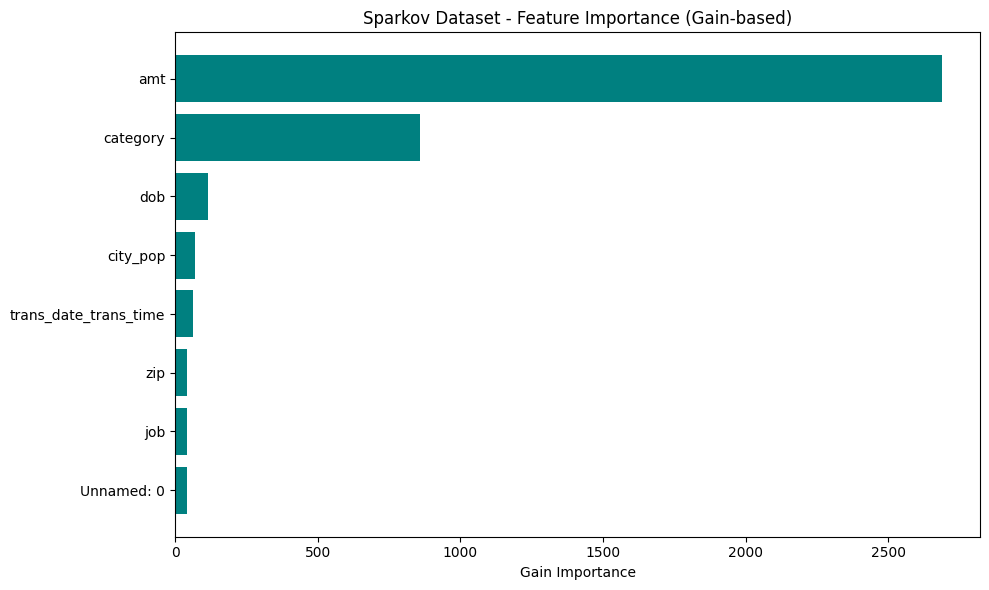


Top 5 important features (Sparkov Dataset):
                 Feature   Importance
3                    amt  2687.339355
2               category   860.234802
7                    dob   115.997009
5               city_pop    68.444183
1  trans_date_trans_time    64.024193

🔁 Computing Permutation Importance (Sparkov Dataset)...


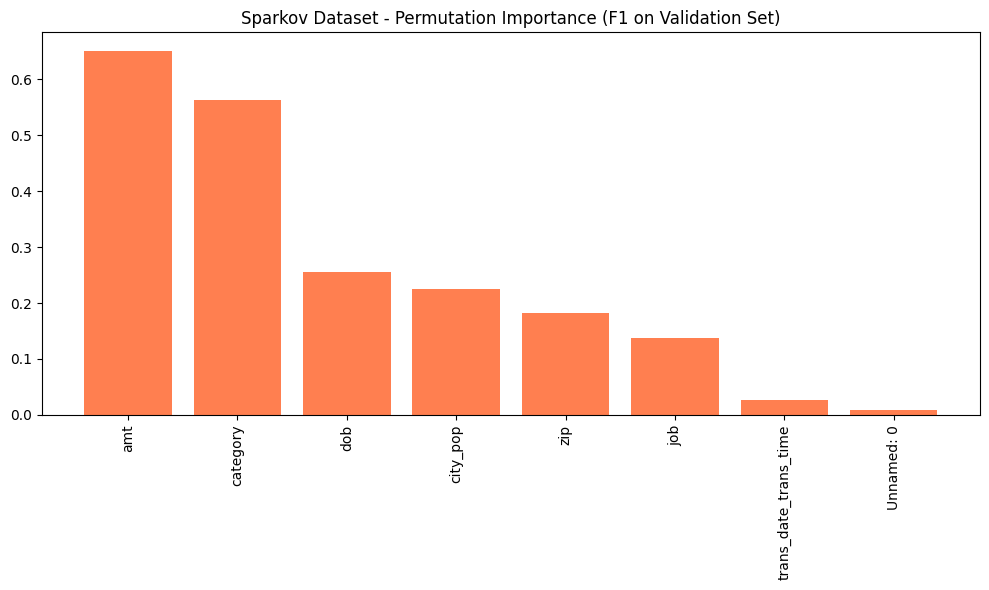


📈 Creating Partial Dependence Plots for top features: ['amt', 'category', 'dob']


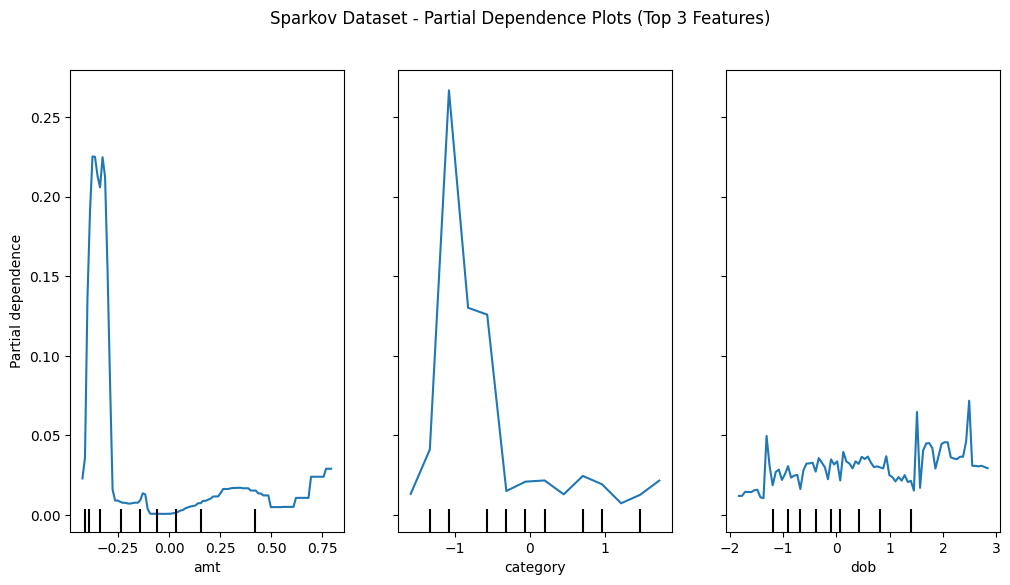


✅ Interpretation completed for Sparkov Dataset.



In [10]:
# ================== XGBOOST MODEL INTERPRETATION ==================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

def interpret_xgboost_model(final_model, X_train, X_val, y_val, dataset_name="Dataset"):
    """
    Gives model interpretation using:
    1. Gain-based Feature Importance
    2. Permutation Importance
    3. Partial Dependence Plots (Top 3 features)
    """
    print(f"\n================= 🔍 INTERPRETATION FOR {dataset_name} =================")

    # ---- 1️⃣ GAIN-BASED FEATURE IMPORTANCE ----
    booster = final_model.get_booster()
    importance = booster.get_score(importance_type='gain')

    if not importance:
        print("⚠️ No importance data found in model.")
        return

    imp_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(imp_df['Feature'], imp_df['Importance'], color='teal')
    plt.gca().invert_yaxis()
    plt.title(f"{dataset_name} - Feature Importance (Gain-based)")
    plt.xlabel("Gain Importance")
    plt.tight_layout()
    plt.show()

    print(f"\nTop 5 important features ({dataset_name}):")
    print(imp_df.head(5))

    # ---- 2️⃣ PERMUTATION IMPORTANCE ----
    print(f"\n🔁 Computing Permutation Importance ({dataset_name})...")
    perm = permutation_importance(
        final_model,
        X_val,
        y_val,
        scoring='f1',
        n_repeats=10,
        random_state=42
    )

    sorted_idx = perm.importances_mean.argsort()[::-1]

    plt.figure(figsize=(10,6))
    plt.bar(range(len(sorted_idx)), perm.importances_mean[sorted_idx], color='coral')
    plt.xticks(range(len(sorted_idx)), X_val.columns[sorted_idx], rotation=90)
    plt.title(f"{dataset_name} - Permutation Importance (F1 on Validation Set)")
    plt.tight_layout()
    plt.show()

    # ---- 3️⃣ PARTIAL DEPENDENCE PLOTS (PDPs) ----
    top_features = imp_df['Feature'].head(3).tolist()
    print(f"\n📈 Creating Partial Dependence Plots for top features: {top_features}")

    fig, ax = plt.subplots(figsize=(12, 6))
    PartialDependenceDisplay.from_estimator(final_model, X_val, features=top_features, ax=ax)
    plt.suptitle(f"{dataset_name} - Partial Dependence Plots (Top 3 Features)")
    plt.show()

    print(f"\n✅ Interpretation completed for {dataset_name}.\n")

# ================== RUN INTERPRETATION ==================

# --- For EU Dataset ---
interpret_xgboost_model(final_model, X_train, X_val, y_val, dataset_name="EU Dataset")

# --- For Sparkov Dataset ---
interpret_xgboost_model(final_model, X_train, X_val, y_val, dataset_name="Sparkov Dataset")


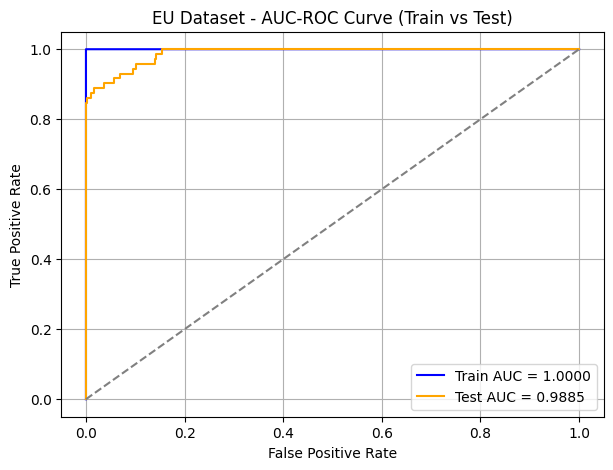

✅ EU Dataset - Train AUC: 1.0000 | Test AUC: 0.9885


In [58]:
# ================== IMPORTS ==================
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ================== FUNCTION ==================
def plot_train_test_auc(final_model, X_train, y_train, X_test, y_test, dataset_name):
    """
    Plots ROC curve for both training and testing sets.
    Works with XGBoost, CatBoost, LightGBM, etc.
    """

    # --- Predict probabilities ---
    y_train_prob = final_model.predict_proba(X_train)[:, 1]
    y_test_prob = final_model.predict_proba(X_test)[:, 1]

    # --- Compute ROC curves ---
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

    # --- Compute AUC scores ---
    auc_train = roc_auc_score(y_train, y_train_prob)
    auc_test = roc_auc_score(y_test, y_test_prob)

    # --- Plot ---
    plt.figure(figsize=(7, 5))
    plt.plot(fpr_train, tpr_train, color='blue', label=f"Train AUC = {auc_train:.4f}")
    plt.plot(fpr_test, tpr_test, color='orange', label=f"Test AUC = {auc_test:.4f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f"{dataset_name} - AUC-ROC Curve (Train vs Test)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f"✅ {dataset_name} - Train AUC: {auc_train:.4f} | Test AUC: {auc_test:.4f}")

# ================== CALL FOR EU DATASET ==================
# Make sure these variables exist from your training code
# final_model → trained model for EU dataset
# X_res, y_res → resampled training data (after SMOTEENN)
# X_test, y_test → test data
plot_train_test_auc(final_model_eu, X_res_eu, y_res_eu, X_test_eu, y_test_eu, "EU Dataset")
